In [1]:
import os, glob, time, datetime
import numpy as np
import imageio
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding, interpolated_embedding_lookup
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image, centering_image, save_gif
from common.train import interpolation
from get_data.package import pickle_interpolation_data

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

### Hyperparameter setting

In [3]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 18
IMG_SIZE = 128
EMBEDDING_DIM = 128

from_model_path = './model_checkpoint/'
data_dir = './interpolation/dataset/'
fixed_dir = './fixed_sample/'

### 150epoch trained model

In [4]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()

In [5]:
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

150 epoch trained model has restored


### Embeddings

In [6]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

In [7]:
font_filter = [9, 14, 5, 11, 7, 0, 6, 8, 16, 19, 21, 18, 13, 20, 15, 17, 12, 10]
font_filter_plus = font_filter + [font_filter[0]]
interpolated_font_ids = [(i, font_filter_plus[font_filter.index(i)+1]) for i in font_filter]
print(len(interpolated_font_ids))
interpolated_font_ids

18


[(9, 14),
 (14, 5),
 (5, 11),
 (11, 7),
 (7, 0),
 (0, 6),
 (6, 8),
 (8, 16),
 (16, 19),
 (19, 21),
 (21, 18),
 (18, 13),
 (13, 20),
 (20, 15),
 (15, 17),
 (17, 12),
 (12, 10),
 (10, 9)]

In [8]:
fixed_char_ids = torch.load(os.path.join(data_dir, 'fixed_char_ids.pkl')).numpy()
len(fixed_char_ids)

24

In [9]:
data_provider = TrainDataProvider(data_dir, train_name="interpolation_data.obj", val=False)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 432 examples
train examples -> 432
total batches: 24


---

### Grid: interpolation step

In [10]:
grids = [0., 0.15, 0.48, 0.54, 0.57, 0.63, 0.53, 0.59, 0.62, 0.85]
print(len(grids))

10


여러번의 시행착오를 거쳐 확 변하는 구간을 찾아서 그 부분을 많이 늘린다.

## Image Centering
- 저장한 image들이 각각 다른 source로 생성되어서, center가 다 안맞는다.

- centering을 따로 해줄 필요

### interpolation 함수를 보완한다. 
- `real_source` 를 Encoder에 넣기 전에 cleansing (centering, size_fitting) 진행

### image 전부 저장하기

In [11]:
save_path = './interpolation/images/'
grid_results = interpolation(data_provider, grids, fixed_char_ids, interpolated_font_ids, \
                             embeddings, En, De, batch_size=BATCH_SIZE, save_path=save_path, \
                             img_size=128, GPU=True)

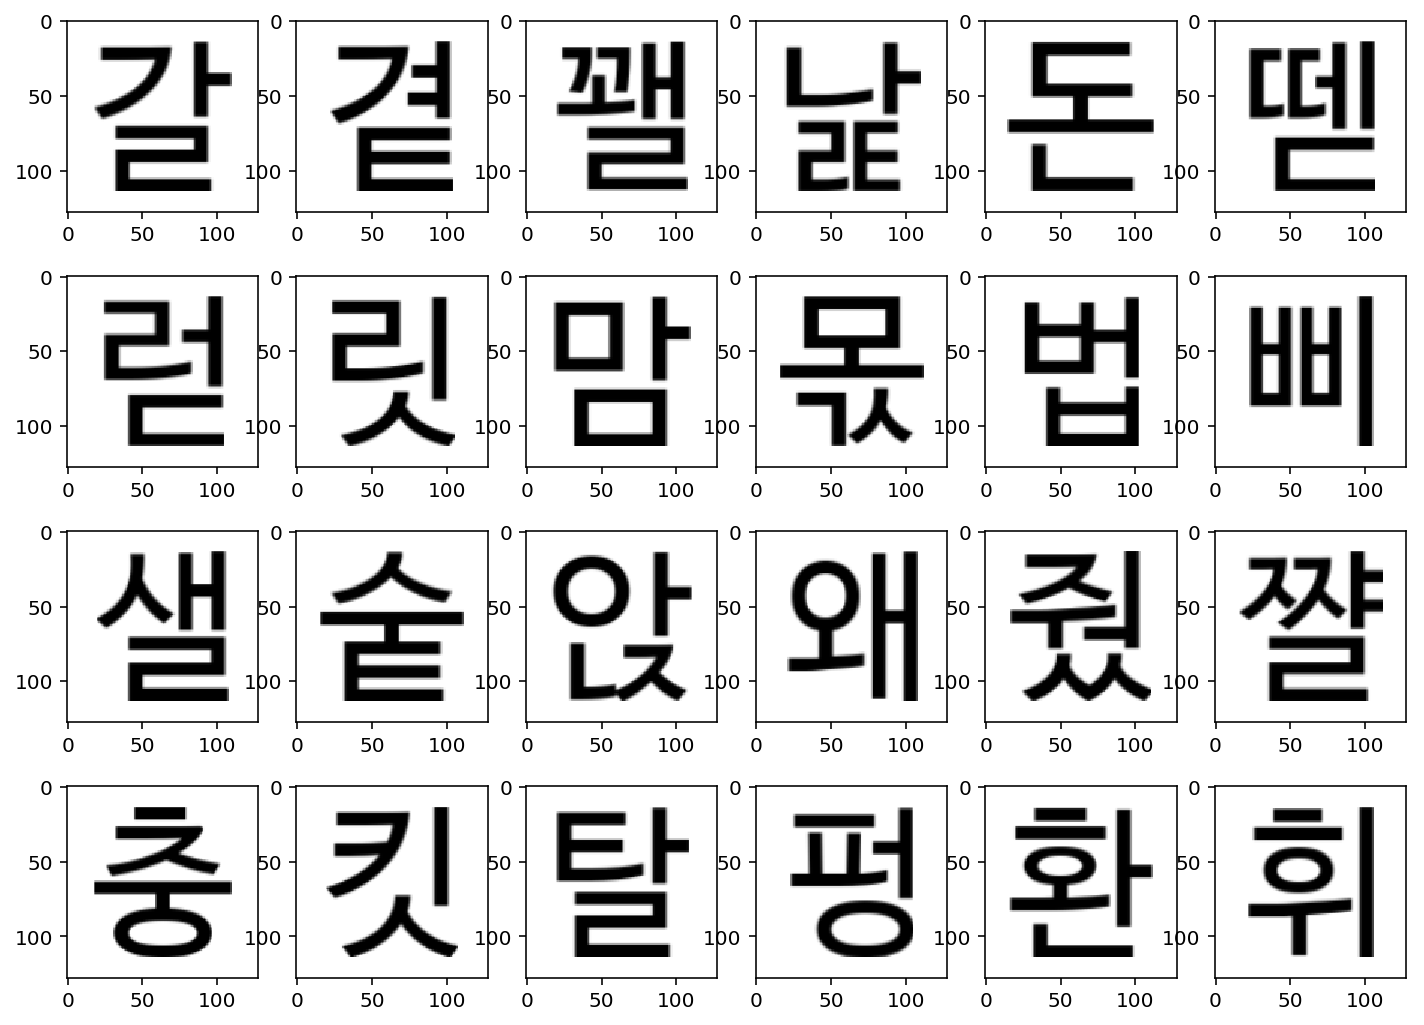

In [12]:
fontid = interpolated_font_ids[0]

plt.figure(figsize=(12, 9))
idx = 1
fake_images = np.array([grid_results[fontid][charid][0] for charid in fixed_char_ids])
for image in fake_images:
    plt.subplot(4, 6, idx)
    plt.imshow(image.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    idx += 1
plt.show()

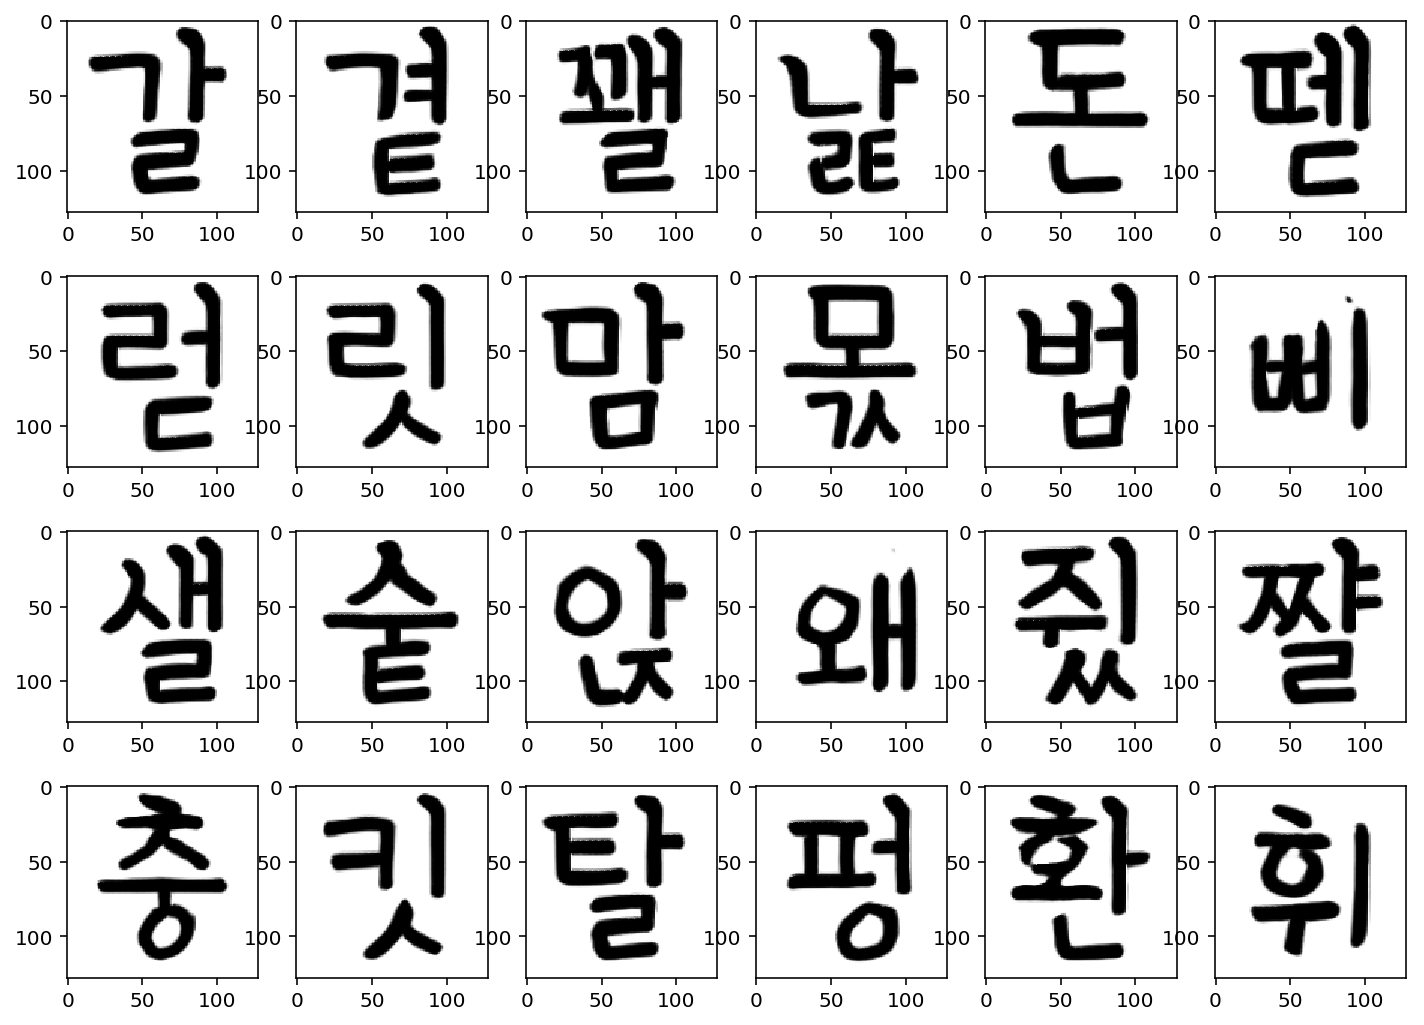

In [13]:
fontid = interpolated_font_ids[0]

plt.figure(figsize=(12, 9))
idx = 1
fake_images = np.array([grid_results[fontid][charid][2] for charid in fixed_char_ids])
for fontid, image in enumerate(fake_images):
    plt.subplot(4, 6, idx)
    plt.imshow(image.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    idx += 1
plt.show()

- 이미지들이 중앙에 이쁘게 배열되고, 크기도 일정!!

### Load images

In [14]:
image_path = './interpolation/images'
filenames = sorted(glob.glob(os.path.join(image_path, "*.png")))
len(filenames)

180

- 총 180개의 이미지

## GIF file 생성

In [15]:
gif_path = './interpolation/gifz'
image_path = './interpolation/images'
file_name = 'font_to_font_interpolation.gif'

save_gif(gif_path, image_path, file_name)